In [1]:
from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#comet ml  - creating an experiment#

experiment = Experiment(
    api_key="", ## removed the api key value while sharing
    project_name="coli-assignment-4",
    workspace="gokul",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'D:\\Masters Language Science and Technology\\Computational Linguistics\\Gokul\\Assignment4' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/gokul/coli-assignment-4/d058513e12c8494690f25cbe8112f614



In [ ]:
## Loading the training and test corpus ##

In [3]:
import data

training_filename = 'de_gsd-ud-train.conllu'
dev_filename = 'de_gsd-ud-dev.conllu'
test_filename = 'de_gsd-ud-test.conllu'

train_dataloader, dev_dataloader, test_dataloader, vocabulary, tagset, pretrained_embeddings = data.load(training_filename, dev_filename, test_filename)

In [4]:
## Getting first instance of train dataloader ##
first_data = next(iter(train_dataloader))

# convert the sentence and pos tensors to numpy #
sent = first_data[0][0].numpy()
pos = first_data[0][1].numpy()

In [5]:
itos_sent = vocabulary.get_itos()
itos_pos = tagset.get_itos()

# Printing the sentence and its pos tags in readable format #
print("Sentence : ",' '.join([itos_sent[i] for i in sent]))
print()
print("Tags : ",' '.join([itos_pos[i] for i in pos]))

Sentence :  sehr gute beratung , schnelle behebung der probleme , so stelle ich mir kundenservice vor </s>

Tags :  ADV ADJ NOUN PUNCT ADJ NOUN DET NOUN PUNCT ADV VERB PRON PRON NOUN ADP PUNCT


In [ ]:
## Neural model ##

In [6]:
# I have used GPU to train the model #

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [7]:
class POSTagger(nn.Module):
    def __init__(self, pretrained_embeddings, embedding_dim=300, hidden_dim=256, layers=2, tagset_size=18, dropout_val=0.1):   
        super().__init__()
        ## Used the function from_pretrained() to load the pretrained embeddings ##
        ## Ref : https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html ##
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,num_layers = layers, bidirectional = True)
        self.fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout = nn.Dropout(dropout_val)
        self.fc1 = nn.Linear(hidden_dim,tagset_size)
        
    def forward(self, text):
        embedded = self.embedding(text)
        outputs, (hidden, cell) = self.lstm(embedded.view(len(text), 1, -1))
        predictions = self.fc(outputs.view(len(text), -1))
        predictions = self.dropout(predictions)
        predictions = self.fc1(predictions)
        return predictions

In [8]:
## Using 2 layer bi-LSTM model ##
model = POSTagger(pretrained_embeddings,embedding_dim=300, hidden_dim=256, layers=2, tagset_size=len(tagset.vocab), dropout_val=0.35)
model= model.to(device)

In [9]:
loss = nn.CrossEntropyLoss().to(device)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
print(model)

POSTagger(
  (embedding): Embedding(50506, 300)
  (lstm): LSTM(300, 256, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=256, out_features=18, bias=True)
)


In [12]:
def accuracy(tag_scores,tag):
    '''
        This function is used for computing accuracy
        inputs : Predicted tag scores and correct pos tags 
        output : Acuuracy value
    '''
    _ , predicted_idx = torch.max(tag_scores, 1)
    return torch.sum(predicted_idx == tag).item()/len(tag)
    
def train(train_dataloader, loss, optimizer, model):
    '''
        This function is used for training the model
    '''
    model.train()
    train_total_acc = 0
    train_total_loss = 0
    
    for batch in train_dataloader: 
        # using model.zero_grad() instead of optimizer.zero_grad()# 
        model.zero_grad()
        
        word = batch[0][0].to(device)
        tag = batch [0][1].to(device)
        tag_scores = model(word)
        
        loss_val = loss(tag_scores, tag)
        
        loss_val.backward()
        optimizer.step()

        train_total_loss += loss_val.item()
        
        ## Accuracy ##
        train_total_acc += accuracy(tag_scores,tag)
    
    return train_total_loss, train_total_acc

def evaluate(dev_dataloader, loss, model):
    '''
        This function is used for evaluating the model's performance
    '''
    eval_total_loss = 0
    eval_total_acc = 0
    model.eval()
    for eval_batch in dev_dataloader:
        word = eval_batch[0][0].to(device)
        tag = eval_batch [0][1].to(device)
        tag_scores = model(word)

        loss_val_eval = loss(tag_scores, tag)
        eval_total_loss += loss_val_eval.item()
        
        eval_total_acc += accuracy(tag_scores,tag)
        
    return eval_total_loss, eval_total_acc

In [13]:
import time

# Number of epochs : 25 #
for epoch in range(25):
    print("Epoch : ",epoch+1)
    start_time = time.time()
    
    train_total_loss, train_total_acc = train(train_dataloader, loss, optimizer, model)
    eval_total_loss, eval_total_acc = evaluate(dev_dataloader, loss, model)   
        
    print('Train : Total accuracy : ', train_total_acc/len(train_dataloader))
    experiment.log_metric('Train accuracy : ', train_total_acc/len(train_dataloader), step=epoch)
    print('Train : Loss : ',train_total_loss/len(train_dataloader))
    experiment.log_metric('Train loss : ', train_total_loss/len(train_dataloader), step=epoch)
    print('Dev : Total Accuracy : ',eval_total_acc/len(dev_dataloader))
    experiment.log_metric('Validation accuracy : ', eval_total_acc/len(dev_dataloader), step=epoch)
    print('Dev : Total loss : ',eval_total_loss/len(dev_dataloader))
    experiment.log_metric('Validation loss : ', eval_total_loss/len(dev_dataloader), step=epoch)
    print('Time taken per epoch : ',time.time() - start_time)
    print('________________________________________________________________________________________')

Epoch :  1
Train : Total accuracy :  0.9222045511903498
Train : Loss :  0.2515009833891096
Dev : Total Accuracy :  0.9166274007047809
Dev : Total loss :  0.30089173313068257
Time taken per epoch :  94.64866018295288
________________________________________________________________________________________
Epoch :  2
Train : Total accuracy :  0.9589431195588987
Train : Loss :  0.13187555699798564
Dev : Total Accuracy :  0.926731337697019
Dev : Total loss :  0.2961373989674121
Time taken per epoch :  90.79440450668335
________________________________________________________________________________________
Epoch :  3
Train : Total accuracy :  0.9712524246507785
Train : Loss :  0.09081043898894119
Dev : Total Accuracy :  0.9270366318404033
Dev : Total loss :  0.33261098548006474
Time taken per epoch :  90.76082444190979
________________________________________________________________________________________
Epoch :  4
Train : Total accuracy :  0.9785649799348958
Train : Loss :  0.06650983889

In [ ]:
## Total time taken for training in GPU : 43 minutes ##

In [14]:
## Testing ##

test_total_loss, test_total_acc = evaluate(test_dataloader, loss, model)
print('Test : Total Accuracy : ',test_total_acc/len(test_dataloader))
print('Test : Total loss : ',test_total_loss/len(test_dataloader))

Test : Total Accuracy :  0.9219948053233035
Test : Total loss :  0.8234404376637896


In [15]:
## Saving model ##
torch.save(model.state_dict(), 'postagger-lstm-model.pt')

In [16]:
## Stoping the transfer of data to comet ml #
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/gokul/coli-assignment-4/d058513e12c8494690f25cbe8112f614
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Train accuracy :  [25]      : (0.9222045511903498, 0.9935119617579036)
COMET INFO:     Train loss :  [25]          : (0.02256796114964189, 0.2515009833891096)
COMET INFO:     Validation accuracy :  [25] : (0.9166274007047809, 0.9314634950202603)
COMET INFO:     Validation loss :  [25]     : (0.2961373989674121, 0.7569209296598369)
COMET INFO:     loss [34534]                : (0.0, 4.423430442810059)
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebook            : 1
COMET INFO:    

I trained the models by varying the hyperparameters and noticed that the small change learning rate and dropout values have significant impact on the performance of this model.

# Training Accuracy #

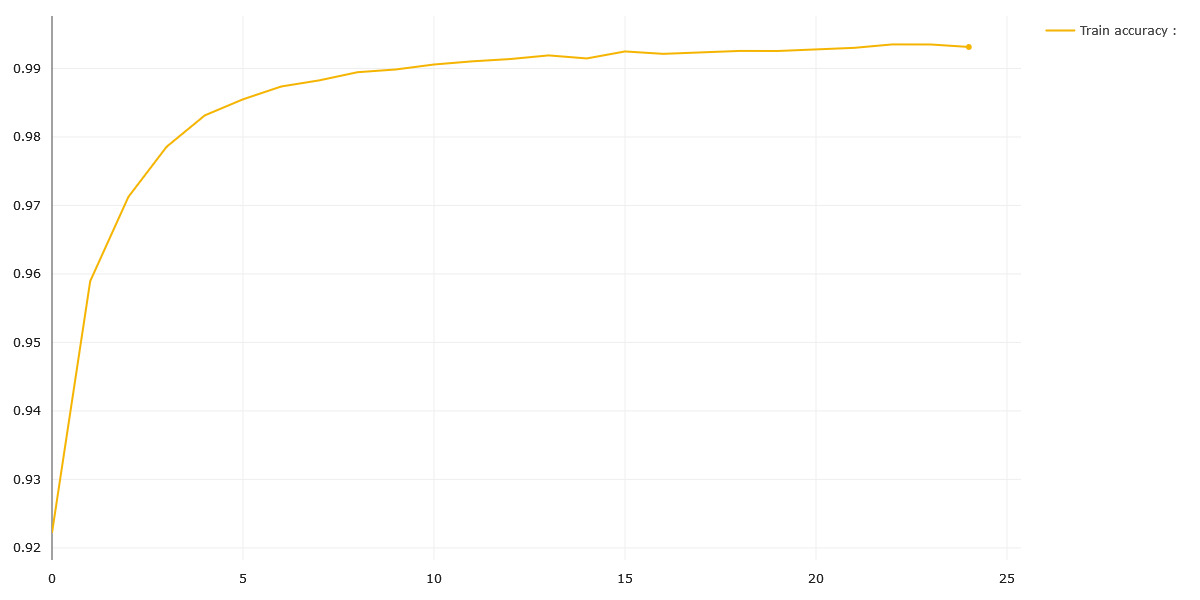

# Training loss

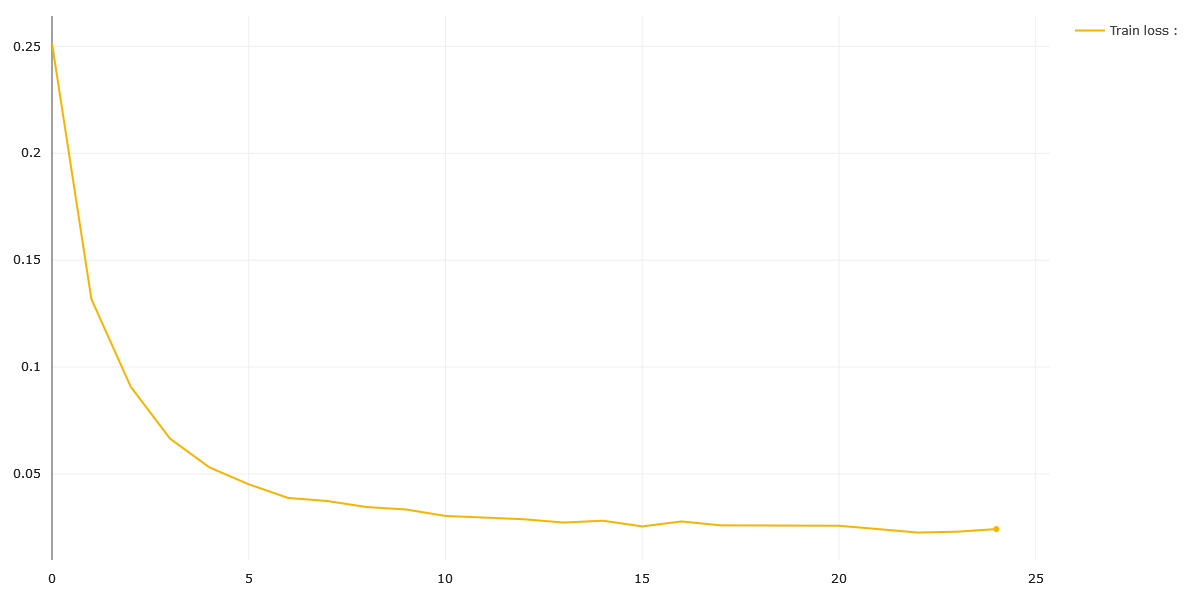

# Validation accuracy

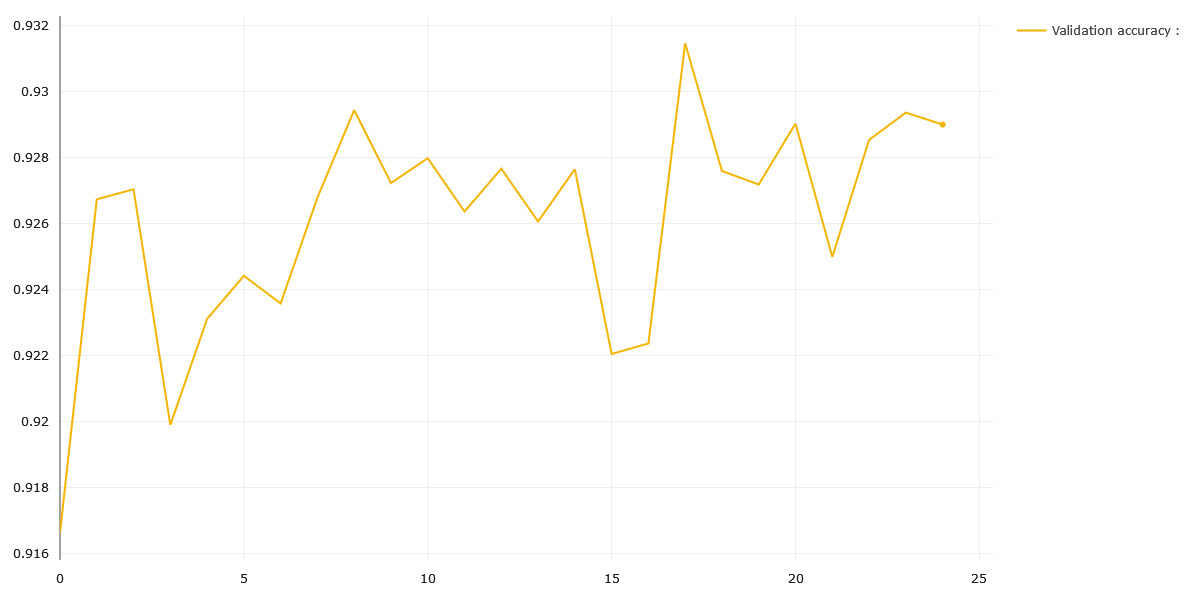

# Validation loss

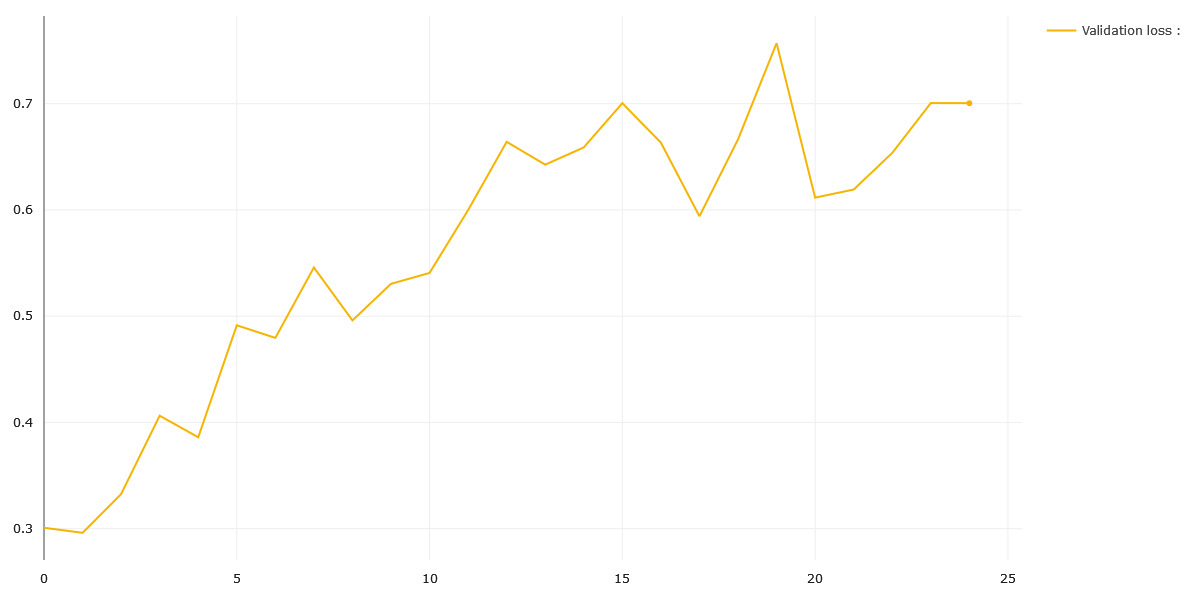

# Additional Work 

In [17]:
## GRU Model ##

class POSTagger_GRU(nn.Module):
    def __init__(self, pretrained_embeddings, embedding_dim=300, hidden_dim=256, layers=2, tagset_size=18, dropout_val=0.1):   
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings,freeze=True)
        self.gru = nn.GRU(embedding_dim, hidden_dim,num_layers = layers, bidirectional = True)
        self.fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout = nn.Dropout(dropout_val)
        self.fc1 = nn.Linear(hidden_dim,tagset_size)
        
    def forward(self, text):
        embedded = self.embedding(text)
        outputs, hidden = self.gru(embedded.view(len(text), 1, -1))
        predictions = self.fc(outputs.view(len(text), -1))
        predictions = self.dropout(predictions)
        predictions = self.fc1(predictions)
        return predictions

In [51]:
model_gru = POSTagger_GRU(pretrained_embeddings,embedding_dim=300, hidden_dim=256, layers=2, tagset_size=len(tagset.vocab), dropout_val=0.25)
model_gru= model_gru.to(device)

In [52]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters : ', count_parameters(model_gru))

Number of trainable parameters :  2175762


In [53]:
print(model_gru)

POSTagger_GRU(
  (embedding): Embedding(50506, 300)
  (gru): GRU(300, 256, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=256, out_features=18, bias=True)
)


In [40]:
loss = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
import time

for epoch in range(25):
    print("Epoch : ",epoch)
    start_time = time.time()
    
    train_total_loss, train_total_acc = train(train_dataloader, loss, optimizer, model_gru)
    eval_total_loss, eval_total_acc = evaluate(dev_dataloader, loss, model_gru)   
        
    print('Train : Total accuracy : ', train_total_acc/len(train_dataloader))
    print('Train : Loss : ',train_total_loss/len(train_dataloader))
    print('Dev : Total Accuracy : ',eval_total_acc/len(dev_dataloader))
    print('Dev : Total loss : ',eval_total_loss/len(dev_dataloader))
    print('Time taken per epoch : ',time.time() - start_time)
    print('________________________________________________________________________________________')
    
test_total_loss, test_total_acc = evaluate(test_dataloader, loss, model_gru)
print('Test : Total Accuracy : ',test_total_acc/len(test_dataloader))
print('Test : Total loss : ',test_total_loss/len(test_dataloader))

Epoch :  0
Train : Total accuracy :  0.91777076716621
Train : Loss :  0.27696469478710956
Dev : Total Accuracy :  0.907577895456982
Dev : Total loss :  0.36180647598072196
Time taken per epoch :  85.7359938621521
________________________________________________________________________________________
Epoch :  1
Train : Total accuracy :  0.9461206271642957
Train : Loss :  0.1823803491581365
Dev : Total Accuracy :  0.9110531407885458
Dev : Total loss :  0.39362560660745577
Time taken per epoch :  83.41207337379456
________________________________________________________________________________________
Epoch :  2
Train : Total accuracy :  0.9532401600541166
Train : Loss :  0.15862903045503315
Dev : Total Accuracy :  0.9221382916221966
Dev : Total loss :  0.3641074964246483
Time taken per epoch :  83.73533964157104
________________________________________________________________________________________
Epoch :  3
Train : Total accuracy :  0.9564426738529939
Train : Loss :  0.14872521311929

In [ ]:
## Total time taken on training on GPU for GRU model : 35 minutes ##

## GRU model takes 8 mins (approx) less than the lstm model for training and ## 
## the accuracy of GRU model is 0.6 (approx) less than lstm model ##